In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn

In [2]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(2,20),
            nn.Tanh(),
            nn.Linear(20,30),
            nn.Tanh(),
            nn.Linear(30,30),
            nn.Tanh(),
            nn.Linear(30,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,1)
        )
    
    def forward(self,x):
        return self.net(x)

In [3]:
class Problem_Definition:
    def __init__(self):
        
        self.model = PINN()
        
        self.h = 0.1 
        self.k = 0.1
        
        x = torch.arange(-1,1+self.h,self.h)
        t = torch.arange(0,1+self.k,self.k)
        
        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T 
        
        # Boundary conditions
        
        bc1 = torch.stack(torch.meshgrid(x[0],t)).reshape(2,-1).T
        bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T
        
        
        # Initial condition
    
        ic = torch.stack(torch.meshgrid(x,t[0])).reshape(2,-1).T
        self.X_train = torch.cat([bc1,bc2,ic])
        
        # Initializing Targets
        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic = -torch.sin(math.pi * ic[:,0])
        
        self.Y1_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.Y_train = self.Y1_train.unsqueeze(1)
        
    
        self.X.requires_grad = True
       
     # Test 
        """
        print(self.X.shape)
        print(ic.shape)
        print(bc1.shape)
        print(bc2.shape)
        print(self.X_train.shape)
        print('-'*100)
        print(y_ic.shape)
        print(y_bc1.shape)
        print(y_bc2.shape)
        print(self.Y1_train.shape)
        print(self.Y_train.shape) """
        
    
      # Optimizer
        
        self.adam = torch.optim.Adam(self.model.parameters(),1e-3)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 50000,
            max_eval = 50000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )
        
        self.criterion = torch.nn.MSELoss()
        self.iter = 1
        
    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()
        
        Y_pred = self.model(self.X_train)
        loss_data = self.criterion(Y_pred,self.Y_train)
        
        u = self.model(self.X)
        
        dU_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0] # To get out of the tuple
        
        du_dx = dU_dX[:,0]
        du_dt = dU_dX[:,1]
        
        dU_dXX = torch.autograd.grad(
            dU_dX,
            self.X,
            grad_outputs = torch.ones_like(dU_dX),
            create_graph = True,
            retain_graph = True
        )[0] # To get out of the tuple
        
        du_dxx = dU_dXX[:,0]
        
        eqn = du_dt + u.squeeze()*du_dx - (0.01/math.pi)*du_dxx - torch.sin(self.X[:,0])* torch.cos(self.X[:,1])
        eqn_lhs = du_dt + u.squeeze()*du_dx 
        eqn_rhs = (0.01/math.pi)*du_dxx + torch.sin(self.X[:,0])* torch.cos(self.X[:,1])
        loss_pde = self.criterion(eqn,torch.zeros_like(eqn))
        


        loss = loss_data + loss_pde
        loss.backward()
        
        
        if self.iter% 100 == 0:
            print(f"Iteration : {self.iter}, Loss : {loss.item()}")
        self.iter = self.iter + 1
        
        return loss
        
    def train(self):
        self.model.train()
        for i in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)
    
   
    def eval_(self):
        self.model.eval()

In [4]:
# Execution
run = Problem_Definition()
run.train()

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Iteration : 100, Loss : 0.14881011843681335
Iteration : 200, Loss : 0.08980847150087357
Iteration : 300, Loss : 0.0783352330327034
Iteration : 400, Loss : 0.06755126267671585
Iteration : 500, Loss : 0.06304369866847992
Iteration : 600, Loss : 0.06035655736923218
Iteration : 700, Loss : 0.058123357594013214
Iteration : 800, Loss : 0.05506950616836548
Iteration : 900, Loss : 0.04886796325445175
Iteration : 1000, Loss : 0.04087818041443825
Iteration : 1100, Loss : 0.02644144557416439
Iteration : 1200, Loss : 0.0243175458163023
Iteration : 1300, Loss : 0.023447897285223007
Iteration : 1400, Loss : 0.023034922778606415
Iteration : 1500, Loss : 0.022728733718395233
Iteration : 1600, Loss : 0.02254193089902401
Iteration : 1700, Loss : 0.022463679313659668
Iteration : 1800, Loss : 0.022335048764944077
Iteration : 1900, Loss : 0.022206751629710197
Iteration : 2000, Loss : 0.02211291901767254
Iteration : 2100, Loss : 0.021997597068548203
Iteration : 2200, Loss : 0.021901005879044533
Iteration : 

In [5]:
h = 0.01
k = 0.01

x = torch.arange(-1,1,h)
t = torch.arange(0,1,k)

X= torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X= X

In [6]:
model = run.model
model.eval()
with torch.no_grad():
    y_pred = model(X)
    y_pred = y_pred.reshape(len(x),len(t)).numpy()

In [7]:
y_pred

array([[ 0.204558  ,  0.1946242 ,  0.1850615 , ..., -0.25528288,
        -0.25818253, -0.26105592],
       [ 0.21984564,  0.20943685,  0.1994202 , ..., -0.25189453,
        -0.25479728, -0.25767303],
       [ 0.23562397,  0.22472702,  0.21424367, ..., -0.2483828 ,
        -0.25128847, -0.25416633],
       ...,
       [-0.2460285 , -0.2343866 , -0.22322708, ...,  0.24187525,
         0.24472074,  0.24753131],
       [-0.22780879, -0.21666604, -0.20598906, ...,  0.24547882,
         0.24831612,  0.25111973],
       [-0.20996894, -0.1993202 , -0.18911968, ...,  0.24893273,
         0.2517624 ,  0.25455916]], dtype=float32)

In [8]:
sns.set_style('white')
plt.figure(figsize=(5,3), dpi = 5000)
sns.heatmap(y_pred, cmap = 'jet')

<Axes: >

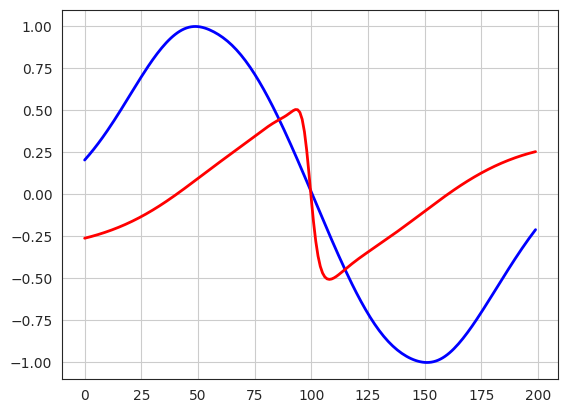

In [9]:
plt.figure(1)
plt.plot(y_pred[:,0], 'b', linewidth = 2)
plt.plot(y_pred[:,-1],'r', linewidth = 2)
plt.grid('True')
